In [30]:
# Load library
import csv
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

from itertools import cycle

from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.preprocessing import label_binarize
# User Define
from test_LE import saveLabelEncoder,loadLabelEncoder
import importlib
# import importlib; importlib.reload(modulename)
# https://docs.python.org/3/tutorial/modules.html

In [3]:
# Load Data
data_ = pd.read_csv("data/data_odd_2005.csv", encoding='utf-8')

In [4]:
data = data_.iloc[:,2:].copy()

In [13]:
le = preprocessing.LabelEncoder()

le.fit(data['tournament'])
np.save('tournament.npy', le.classes_)
data['tournament'] = le.transform(data['tournament'])

le.fit(data['result'])
np.save('result.npy', le.classes_)
data['result'] = le.transform(data['result'])

x = np.concatenate((data['team_1'],data['team_2']), axis=0)
le.fit(x)
np.save('country.npy', le.classes_)
data['team_1'] = le.transform(data['team_1'])
data['team_2'] = le.transform(data['team_2'])
data['home_team'] = le.transform(data['home_team'])

In [7]:
# encoder = preprocessing.LabelEncoder()
file = 'result.npy'
encoder = loadLabelEncoder(file)
encoder.classes_

array(['draw', 'lose', 'win'], dtype=object)

In [81]:
encoder = preprocessing.LabelEncoder()
encoder.classes_ = np.load('result.npy')

In [15]:
# Split data training and testing
x_train, x_test, y_train, y_test = train_test_split(data.iloc[:,:-1],data.iloc[:,-1:],test_size=0.3, random_state=85)

In [16]:
# Fit a simple LR
model_LR = LogisticRegression(multi_class='ovr').fit(x_train,y_train.squeeze())

In [455]:
model_LR.score(x_train,y_train.squeeze())

0.59024147373661939

In [456]:
model_LR.score(x_test,y_test.squeeze())

0.59581881533101044

In [17]:
y_pred = model_LR.predict(x_test)

In [401]:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    import itertools
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



In [469]:
cnf_matrix = confusion_matrix(y_test, y_pred)
cnf_matrix

array([[  3, 233, 193],
       [  4, 574,  99],
       [ 10, 157, 449]])

Confusion matrix, without normalization
[[  3 233 193]
 [  4 574  99]
 [ 10 157 449]]


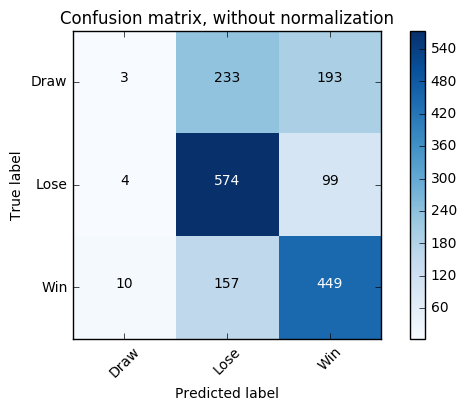

In [405]:
# np.set_printoptions(precision=2)
class_names = np.array(['Draw','Lose','Win'])
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,title='Confusion matrix, without normalization')


In [481]:
y_pred

array([1, 2, 1, ..., 1, 2, 1], dtype=int64)

In [492]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix


In [496]:
print(classification_report(y_test.squeeze(), y_pred))

             precision    recall  f1-score   support

          0       0.18      0.01      0.01       429
          1       0.60      0.85      0.70       677
          2       0.61      0.73      0.66       616

avg / total       0.49      0.60      0.52      1722



In [18]:
from sklearn.preprocessing import label_binarize
# Binarize the output
y = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y.shape[1]


In [19]:
y_score = model_LR.decision_function(x_test)

In [20]:
y_score.shape

(1722, 3)

In [505]:
y_train.shape

(4017, 1)

In [21]:
y_test.shape

(1722, 1)

In [25]:
from sklearn.metrics import roc_curve,auc,'interp' 

In [ ]:
from sklearn import.metrics import roc_curve,auc,'interp' 

In [26]:
y_score = model_LR.decision_function(x_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

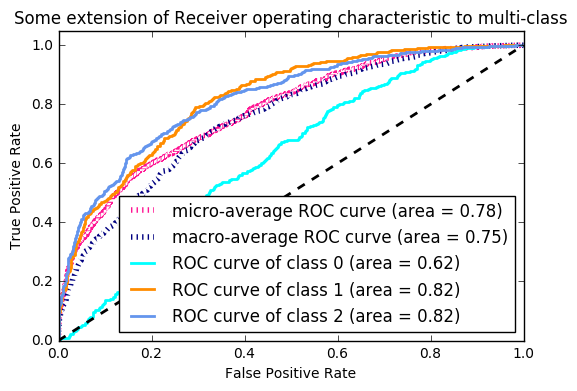

In [32]:
lw = 2
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [498]:
f1_score(y_test.squeeze(), y_pred,labels=[2],average='macro')

0.66175386882829779

In [474]:
y_true = [0, 1, 2, 0, 1, 2]
y_pred = [0, 2, 1, 0, 0, 1]
f1_score(y_true, y_pred, average='macro')  

# f1_score(y_true, y_pred, average='micro')  

# f1_score(y_true, y_pred, average='weighted')  

# f1_score(y_true, y_pred, average=None)

0.26666666666666666

In [331]:
x = np.concatenate((data['team_1'],data['team_2']), axis=0)
le = preprocessing.LabelEncoder()
# le_team = le.fit_transform(x)
le.fit(x)
le.transform(x)
country = np.unique(x)
mapping = dict(zip(country,le.transform(country))) #save this to a pickle file

In [333]:
le.transform(['Vietnam'])

array([192], dtype=int64)

In [288]:
def map_country_num(country_list):    
    return country_list.map(mapping)

In [302]:
# Convert country name
X = data[['team_1','team_2','home_team']].apply(map_country_num)
data.update(X)

In [392]:
data.head()

,team_1,team_2,home_team,tournament,h_win_diff,h_draw,f_goalF_1,f_goalF_2,f_goalA_1,f_goalA_2,f_win_1,f_win_2,f_draw_1,f_draw_2,avg_odds_win_1,avg_odds_draw,avg_odds_win_2,result
0,64,100,100,17,3,2,16,17,12,18,5,2,0,2,2.2343,3.1929,2.8000,2
1,93,134,93,21,0,3,11,17,18,11,6,3,2,3,1.3180,4.1900,8.6980,2
2,153,189,189,21,0,0,17,15,9,12,6,6,2,2,3.1000,3.2000,2.0467,0
3,14,86,14,21,0,1,20,20,12,16,3,6,4,3,2.4629,3.1786,2.5429,0
4,49,72,72,21,5,3,11,8,17,8,3,4,5,4,3.0778,3.0667,2.1478,1


In [335]:
encoder = preprocessing.LabelEncoder()
encoder.classes_ = np.load('country.npy')

In [336]:
encoder.transform(['Vietnam'])

array([192], dtype=int64)

In [320]:
#  Inverse transform
# data[['team_1']].apply(le.inverse_transform)
data['re_team_2'] = encoder.inverse_transform(t.astype(int))

In [311]:
t

array([64, 93, 153, ..., 26, 43, 37], dtype=object)

In [319]:
t = data[['team_2']]
t.head()

,team_2
0,100
1,134
2,189
3,86
4,72


In [305]:
t = t.as_matrix().squeeze()

In [310]:
type(t)

numpy.ndarray

In [295]:
t.as_matrix().squeeze().shape

(5739,)

In [268]:
df_encoded = t.apply(le.fit_transform)
df_encoded.head()

,tournament
0,17
1,21
2,21
3,21
4,21


In [261]:
np.array([t])

ValueError: cannot copy sequence with size 5739 to array axis with dimension 1

In [267]:
# transform tournament and result
le = preprocessing.LabelEncoder()
# le.fit_transform(t.as_matrix().squeeze())

In [79]:
data.iloc[:,2:4].head()

,team_1,team_2
0,Finland,Latvia
1,Japan,North Korea
2,Saudi Arabia,Uzbekistan
3,Bahrain,Iran
4,Denmark,Greece


In [206]:
data.iloc[:,2:].as_matrix()

array([['Finland', 'Latvia', 'Latvia', ..., 3.1929, 2.8, 'win'],
       ['Japan', 'North Korea', 'Japan', ..., 4.19, 8.698, 'win'],
       ['Saudi Arabia', 'Uzbekistan', 'Uzbekistan', ..., 3.2, 2.0467,
        'draw'],
       ..., 
       ['Brazil', 'Paraguay', 'Brazil', ..., 3.7164, 6.3271, 'draw'],
       ['Costa Rica', 'Mexico', 'Mexico', ..., 3.5066, 1.7109999999999999,
        'draw'],
       ['Chile', 'Peru', 'Chile', ..., 4.2772, 7.968999999999999, 'win']], dtype=object)

In [52]:
X['team_1'].as_matrix()

array(['Finland', 'Japan', 'Saudi Arabia', ..., 'Brazil', 'Costa Rica',
       'Chile'], dtype=object)

In [230]:
map_country_num('Vietnam')

192

In [247]:
X = data.iloc[:,2:5]
X.head()

,team_1,team_2,home_team
0,Finland,Latvia,Latvia
1,Japan,North Korea,Japan
2,Saudi Arabia,Uzbekistan,Uzbekistan
3,Bahrain,Iran,Bahrain
4,Denmark,Greece,Greece


In [248]:
map_country_num(X.iloc[0,:])

team_1        64
team_2       100
home_team    100
Name: 0, dtype: int64

In [251]:
X_2 = X[['team_1','team_2']].apply(map_country_num)
X.update(X_2)

In [252]:
X.head()

,team_1,team_2,home_team
0,64,100,Latvia
1,93,134,Japan
2,153,189,Uzbekistan
3,14,86,Bahrain
4,49,72,Greece


In [16]:
# Split data training and testing
data_train,data_test = train_test_split(data,test_size=0.3, random_state=85)

In [17]:
print(data_train.shape)
print(data_test.shape)

(4017, 20)
(1722, 20)


In [18]:
data_train.head()

,id,date,team_1,team_2,home_team,tournament,h_win_diff,h_draw,f_goalF_1,f_goalF_2,f_goalA_1,f_goalA_2,f_win_1,f_win_2,f_draw_1,f_draw_2,avg_odds_win_1,avg_odds_draw,avg_odds_win_2,result
3679,33576,6/2/2012,Liberia,Senegal,Senegal,FIFA World Cup qualification,-5,4,11,11,8,8,2,3,4,1,14.2970,6.9000,1.1230,lose
3990,34032,10/13/2012,Namibia,Rwanda,Namibia,Friendly,-1,1,8,23,4,10,4,3,4,4,2.1000,3.3000,3.0000,draw
4234,34390,2/6/2013,Belarus,Hungary,Hungary,Friendly,1,0,11,14,13,16,2,5,4,3,3.1607,3.2572,2.2234,draw
4951,35407,5/24/2014,Moldova,Saudi Arabia,Moldova,Friendly,0,0,16,8,14,18,3,5,3,2,3.2608,3.1119,2.2285,win
5175,35714,9/8/2014,Australia,Saudi Arabia,Australia,Friendly,2,1,26,10,12,13,2,4,1,2,1.9850,3.2525,3.7461,win


In [19]:
data_test.head()

,id,date,team_1,team_2,home_team,tournament,h_win_diff,h_draw,f_goalF_1,f_goalF_2,f_goalA_1,f_goalA_2,f_win_1,f_win_2,f_draw_1,f_draw_2,avg_odds_win_1,avg_odds_draw,avg_odds_win_2,result
4200,34360,1/27/2013,Morocco,South Africa,Morocco,African Cup of Nations,-2,1,7,11,11,5,3,4,4,2,3.0522,3.0930,2.3544,draw
1053,29407,11/21/2007,Armenia,Kazakhstan,Armenia,UEFA Euro qualification,1,1,11,16,6,10,3,3,4,4,1.5889,3.5416,5.4116,lose
2663,31949,10/4/2010,Hong Kong,India,India,Friendly,-3,4,32,15,9,9,1,4,1,1,3.2195,3.2915,2.0655,win
4553,34844,8/14/2013,Croatia,Liechtenstein,Liechtenstein,Friendly,1,0,14,12,11,13,6,1,1,1,1.0867,9.3759,20.4878,win
2760,32145,11/17/2010,Belarus,Oman,Oman,Friendly,0,0,6,15,10,8,4,3,4,3,2.1785,3.1881,3.1796,win


In [ ]:
# Investigate distribution of train and test
data_train

In [82]:
#  pipeline
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA

In [83]:
estimators = [('reduce_dim', PCA()), ('clf', SVC())]
pipe = Pipeline(estimators)

In [84]:
pipe

Pipeline(steps=[('reduce_dim', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [94]:
# First experiement with Pipeline
from sklearn import svm
from sklearn.datasets import samples_generator
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.pipeline import Pipeline
# generate some data to play with
X, y = samples_generator.make_classification(
    n_informative=5, n_redundant=0, random_state=42)
# ANOVA SVM-C
anova_filter = SelectKBest(f_regression, k=5)
clf = svm.SVC(kernel='linear')
anova_svm = Pipeline([('anova', anova_filter), ('svc', clf)])
# You can set the parameters using the names issued
# For instance, fit using a k of 10 in the SelectKBest
# and a parameter 'C' of the svm
anova_svm.set_params(anova__k=10, svc__C=.1).fit(X, y)
                     



prediction = anova_svm.predict(X)
anova_svm.score(X, y)                        

# getting the selected features chosen by anova_filter
anova_svm.named_steps['anova'].get_support()




# Another way to get selected features chosen by anova_filter
# anova_svm.named_steps.anova.get_support()



array([False, False,  True,  True, False, False,  True,  True, False,
        True, False,  True,  True, False,  True, False,  True,  True,
       False, False], dtype=bool)

In [98]:
prediction

array([1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0])

In [97]:
X.shape

(100, 20)

In [96]:
y

array([0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 1])